In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray 
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_laplace, rank_filter

# Problem 1 Scale Space Blob Detection

In [2]:
# 1. Generate a Laplacian of Gaussian filter.
def generate_laplacian_of_gaussian(image, sigma):
    return gaussian_laplace(image, sigma=sigma)

In [3]:
# 2. Build a Laplacian scale space, starting with some initial scale and going for n iterations.
def build_scale_space(image, initial_sigma, k, num_levels):
    log_pyramid = []
    sigma_values = []

    for n in range(num_levels):
        sigma_n = initial_sigma * (k ** n)
        log_image = generate_laplacian_of_gaussian(image, sigma=sigma_n)
        # Scale normalization
        log_image = (sigma_n ** 2) * log_image

        # Square of Laplacian response
        log_image_squared = log_image ** 2

        # Add into the list
        log_pyramid.append(log_image_squared)
        sigma_values.append(sigma_n)
        # Print sigma on different level
        print(f"Level {n+1}: Sigma = {sigma_n:.2f}")
    return log_pyramid, sigma_values

In [4]:
# 3. Perform nonmaximum suppression in scale space.
def nonmaximum_suppression_rank(log_pyramid, size=3, threshold=0.05, upper_threshold=0.8):
    suppressed_pyramid = []
    
    for log_image in log_pyramid:
        # Nonmaximum suppression using rank_filter, -1 means local maximum
        local_max = rank_filter(log_image, -1, size=size)  
        
        # Clip the values to be within the threshold limits
        clipped = np.clip(log_image, threshold, upper_threshold)
        
        # Keep only local maxima after clipping
        suppressed = np.where(log_image == local_max, clipped, 0)
        suppressed_pyramid.append(suppressed)
    
    return suppressed_pyramid

Level 1: Sigma = 2.00
Level 2: Sigma = 3.00
Level 3: Sigma = 4.50
Level 4: Sigma = 6.75
Level 5: Sigma = 10.12
Level 6: Sigma = 15.19
Level 7: Sigma = 22.78
Level 8: Sigma = 34.17
Level 9: Sigma = 51.26
Level 10: Sigma = 76.89
Level 11: Sigma = 115.33
Level 12: Sigma = 173.00
Level 13: Sigma = 259.49
Level 14: Sigma = 389.24
Level 15: Sigma = 583.86


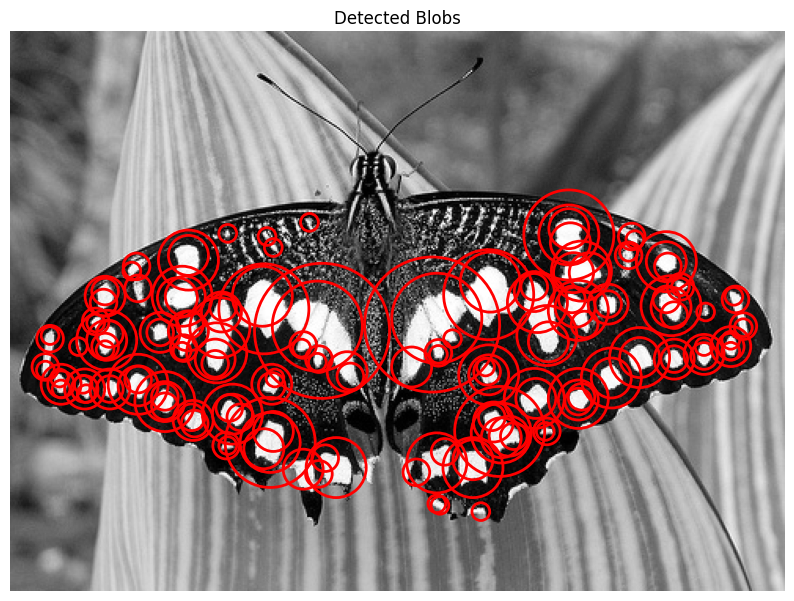

In [5]:
# Hyperparameters
initial_sigma = 2
k = 1.5
num_levels = 15
threshold = 0.15

# Load the image and convert the image to grayscale
image = np.array(Image.open("./project2_images/butterfly.jpg"))
gray_image = rgb2gray(image)

# Step 1: Build the Laplacian scale space
# Step 2: Build a Laplacian scale space, starting with some initial scale and going for n iterations:
log_pyramid, sigma_values = build_scale_space(gray_image, initial_sigma, k, num_levels)

# Step 3: Perform nonmaximum suppression using rank_filter
suppressed_pyramid = nonmaximum_suppression_rank(log_pyramid, size=3, threshold=threshold)

# Step 4: Display resulting circles at their characteristic scales.
# Display blobs with the characteristic scale multiplied by 2
def display_blobs_with_scaled_ellipses(image, suppressed_pyramid, sigma_values, threshold):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    
    for i, suppressed in enumerate(suppressed_pyramid):
        sigma = sigma_values[i]
        # Get the positions of the detected values (Non-zero) in the suppressed pyramid
        y_coords, x_coords = np.nonzero(suppressed > threshold)
        
        for y, x in zip(y_coords, x_coords):
            r = 2 * sigma * np.sqrt(2)  # maximum response are related by the equation in the homework

            # Draw circles with the scaled radius
            ellipse = Ellipse((x, y), 2*r, 2*r, edgecolor='r', fill=False, linewidth=2)
            plt.gca().add_patch(ellipse)
    
    plt.title('Detected Blobs')
    plt.axis('off')
    plt.savefig("./results/question1.jpg", bbox_inches='tight', pad_inches=0)

    plt.show()

# Show the results
display_blobs_with_scaled_ellipses(gray_image, suppressed_pyramid, sigma_values, threshold)


# Problem 2 Difference of Gaussian pyramid Insteadofcalculating

Time taken for DoG pyramid: 0.0098 seconds
Time taken for LoG pyramid: 0.0144 seconds


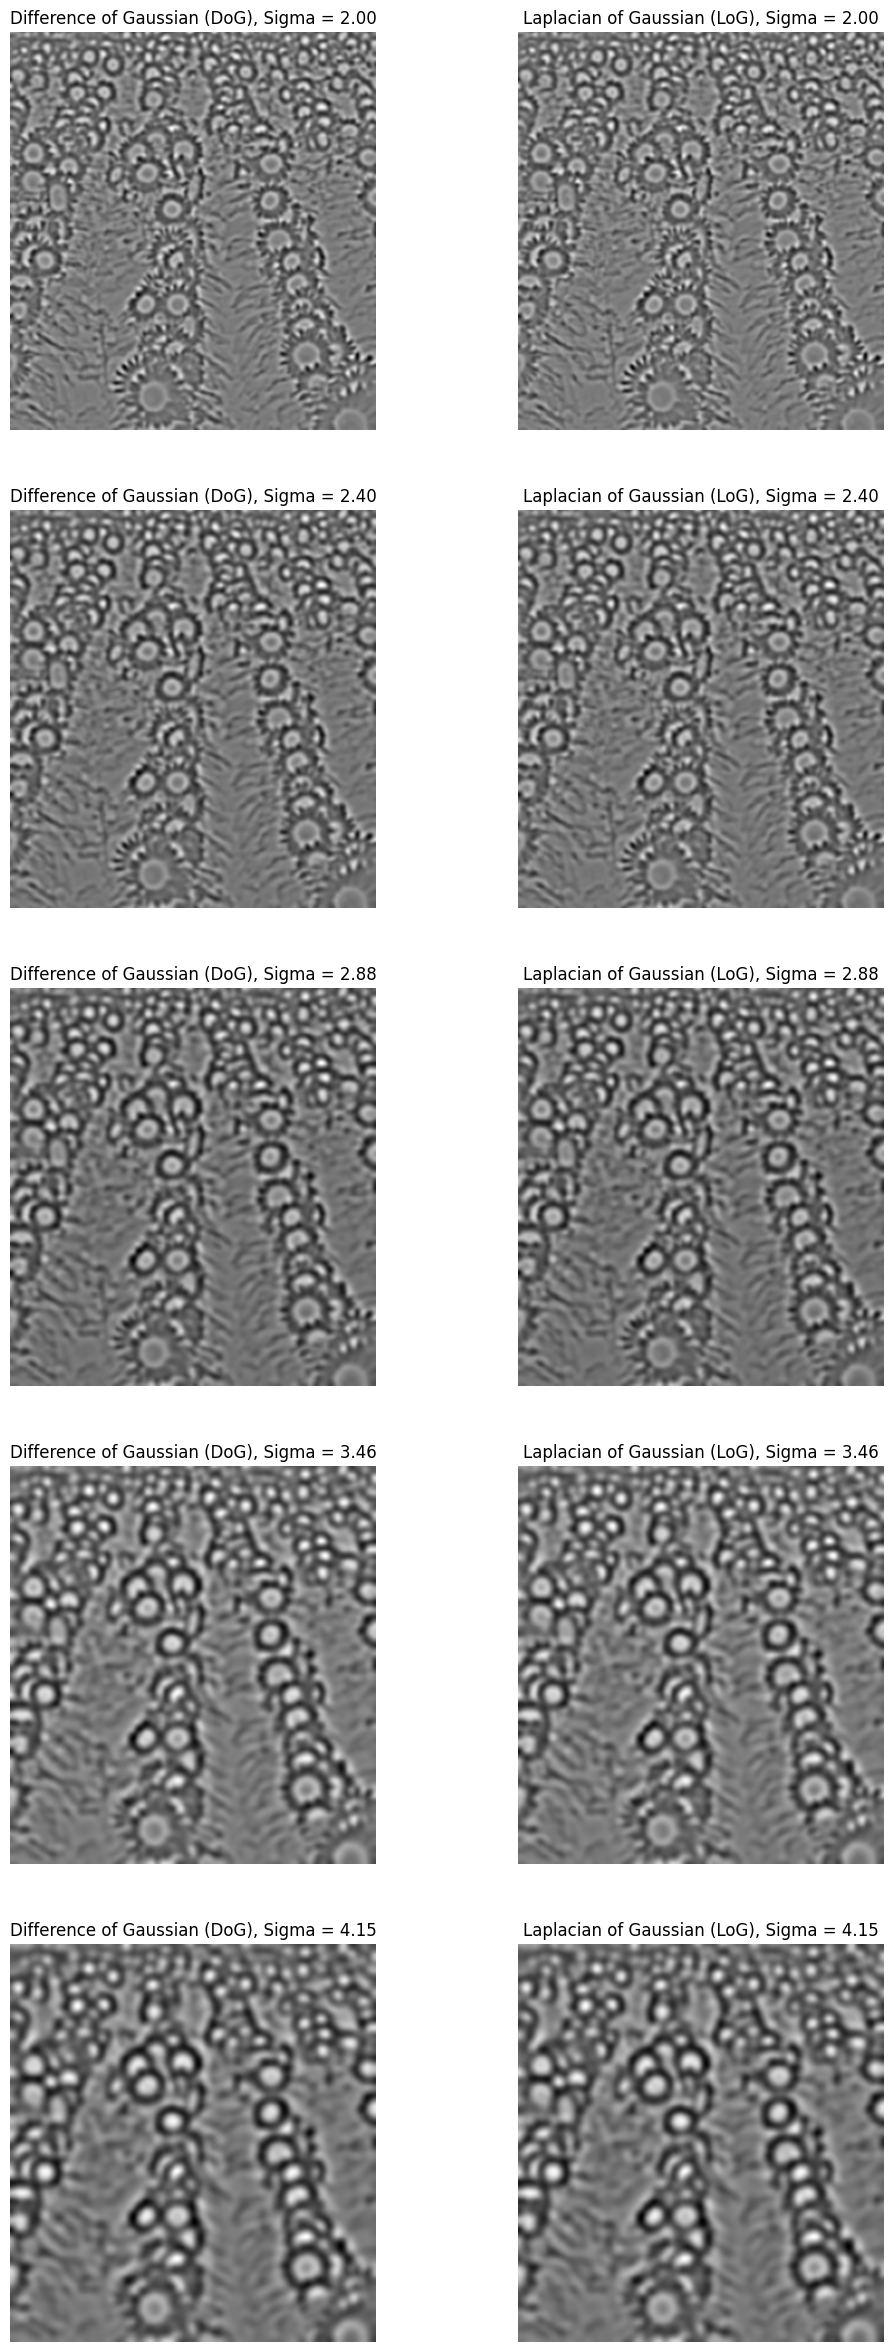

In [6]:
import time
import numpy as np
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_laplace

image = np.array(Image.open("./project2_images/sunflowers.jpg"))
gray_image = color.rgb2gray(image)

# Compute Difference of Gaussian (DoG)
# def difference_of_gaussian(image, sigma, k):
#     G_sigma = gaussian_filter(image, sigma=sigma)
#     G_k_sigma = gaussian_filter(image, sigma=k * sigma)
#     # Compute the difference
#     DoG = G_k_sigma - G_sigma
#     return DoG
 
def difference_of_gaussian(image, sigma, k):
    G_sigma = gaussian_filter(image, sigma=sigma)
    G_k_sigma = gaussian_filter(G_sigma, sigma=(k - 1) * sigma)  # Further blur the already blurred image
    DoG = G_k_sigma - G_sigma
    return DoG


# DoG pyramid
def build_DoG_pyramid(image, initial_sigma, k, num_levels):
    dog_pyramid = []
    sigma_values = []
    
    for n in range(num_levels):
        sigma_n = initial_sigma * (k ** n)
        dog_image = difference_of_gaussian(image, sigma_n, k)
        dog_pyramid.append(dog_image)
        sigma_values.append(sigma_n)
    
    return dog_pyramid, sigma_values

# LoG pyramid
def compare_with_LoG(image, initial_sigma, num_levels):
    log_pyramid = []
    sigma_values = []
    
    for n in range(num_levels):
        sigma_n = initial_sigma * (1.2 ** n)
        log_image = gaussian_laplace(image, sigma=sigma_n)
        # scale normalization
        log_image = (sigma_n ** 2) * log_image
        log_pyramid.append(log_image)
        sigma_values.append(sigma_n)
    
    return log_pyramid, sigma_values

# Plotting function to visualize DoG and LoG filters
def plot_pyramids(image, dog_pyramid, log_pyramid, sigma_values, save_path="./results/question1_all.jpg"):
    # Create a single figure to hold all subplots
    num_levels = len(dog_pyramid)
    plt.figure(figsize=(12, 6 * num_levels)) 

    for i, (dog, log) in enumerate(zip(dog_pyramid, log_pyramid)):

        plt.subplot(num_levels, 2, 2 * i + 1)
        plt.imshow(dog, cmap='gray')
        plt.title(f'Difference of Gaussian (DoG), Sigma = {sigma_values[i]:.2f}')
        plt.axis('off')


        plt.subplot(num_levels, 2, 2 * i + 2)
        plt.imshow(log, cmap='gray')
        plt.title(f'Laplacian of Gaussian (LoG), Sigma = {sigma_values[i]:.2f}')
        plt.axis('off')

    # Save
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


# Calculate running time
def compare_running_time(image, initial_sigma, k, num_levels):
    # Measure time for DoG pyramid
    start_time_dog = time.time()
    dog_pyramid, sigma_values = build_DoG_pyramid(image, initial_sigma, k, num_levels)
    dog_time = time.time() - start_time_dog
    print(f"Time taken for DoG pyramid: {dog_time:.4f} seconds")
    
    # Measure time for LoG pyramid
    start_time_log = time.time()
    log_pyramid, _ = compare_with_LoG(image, initial_sigma, num_levels)
    log_time = time.time() - start_time_log
    print(f"Time taken for LoG pyramid: {log_time:.4f} seconds")
    
    return dog_pyramid, log_pyramid, sigma_values, dog_time, log_time

initial_sigma = 2
k = 1.2 
num_levels = 5 

dog_pyramid, log_pyramid, sigma_values, dog_time, log_time = compare_running_time(
    gray_image, initial_sigma, k, num_levels
)

plot_pyramids(gray_image, dog_pyramid, log_pyramid, sigma_values)


# For report: extra credit

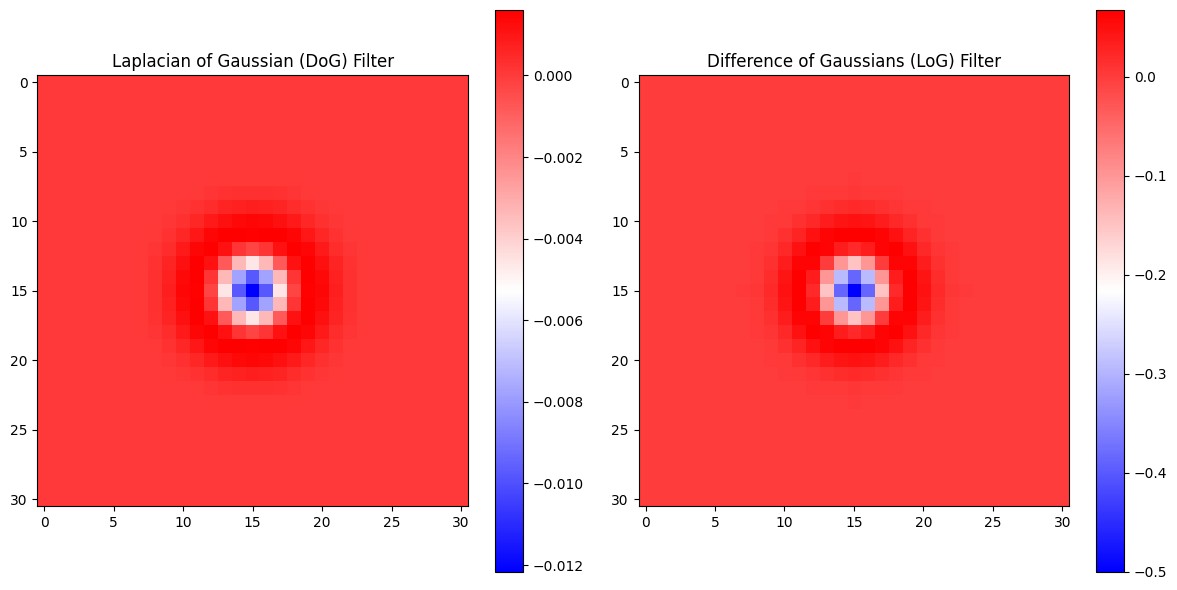

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_laplace, gaussian_filter

# Function to create a 2D Gaussian kernel
def gaussian_kernel(size, sigma):
    # Generate kernel
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)  # Normalize

# Compute the Difference of Gaussians (DoG) filter
def difference_of_gaussians_filter(size, sigma, k):
    G_sigma = gaussian_kernel(size, sigma)
    G_k_sigma = gaussian_kernel(size, k * sigma)
    DoG_filter = G_k_sigma - G_sigma
    return DoG_filter

# Compute the Laplacian of Gaussian (LoG) filter
def laplacian_of_gaussian_filter(size, sigma):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)

    # Gaussian kernel
    gauss = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    
    # Laplacian of Gaussian (LoG) kernel
    log_filter = ((xx**2 + yy**2 - 2 * sigma**2) / (sigma**4)) * gauss
    return log_filter

# Hyperparameters
size = 31  # Kernel size
sigma = 2  # Standard deviation for the Gaussian filter
k = 1.2    # Scale factor for DoG

# Generate LoG and DoG filters
log_filter = laplacian_of_gaussian_filter(size, sigma)
dog_filter = difference_of_gaussians_filter(size, sigma, k)

# Plot the filters
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(dog_filter, cmap='bwr')
plt.title('Laplacian of Gaussian (DoG) Filter')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(log_filter, cmap='bwr')
plt.title('Difference of Gaussians (LoG) Filter')
plt.colorbar()

plt.tight_layout()
plt.savefig("./results/extra_credit.jpg", bbox_inches='tight', pad_inches=0)
plt.show()

# Thank you!
## Finished by Zhenyu Bu.
## Time: 14/10/2024